In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from itertools import product
import gc
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

In [8]:
def read_data(path: str, files: list):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file))
    return dataframes


path = 'D:/EPAM/Predict-Future-Sales/data/'
files = ['sales_train.csv', 'items.csv', 'shops.csv', 'item_categories.csv', 'test.csv']
sales_train, items, shops, item_categories, test = read_data(path, files)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
def remove_outliers(df: pd.DataFrame, max_price: int, max_cnt: int):  
    df = df[df['item_price'] > 0]
    df = df[df['item_price'] < max_price]
    df = df[df['item_cnt_day'] > 0]
    df = df[df['item_cnt_day'] < max_cnt]
    return df


sales_train = remove_outliers(sales_train, 50000, 1000)

In [10]:
def remove_shop_duplicates(df_train: pd.DataFrame, df_test: pd.DataFrame, shop_dups: dict):
    for shop1, shop2 in shop_dups.items():
        df_train.loc[df_train['shop_id'] == shop1, 'shop_id'] = shop2
        df_test.loc[df_test['shop_id'] == shop1, 'shop_id'] = shop2
        

shop_dups = {0: 57, 1: 58, 10: 11, 39: 40}
remove_shop_duplicates(sales_train, test, shop_dups)

### Feature Clustering

In [18]:
class FeatureClustering:
    def __init__(self, feat: str, df: pd.DataFrame, n_month: int):  
        self.feat = feat
        self.feats = list(sorted(df[feat].unique()))
        self.n_month = n_month
    
    def plot_graphs(self, df: pd.DataFrame):
        fig = plt.figure(figsize=(20, 70))
        for i in range(len(self.feats)):
            plt.subplot(17, 5, i + 1)
            plt.plot(df[df[self.feat] == self.feats[i]].groupby(['date_block_num'])['item_cnt_day'].sum())
            plt.title('Month {} {} sales'.format(self.feat, self.feats[i]))
            
    def create_data(self, df: pd.DataFrame, scaler):
        feats_cluster = []
        for feat in self.feats:
            temp = [feat]
            for month in range(self.n_month):
                temp += [df[(df[self.feat] == feat) & (df.date_block_num == month)]['item_cnt_day'].sum()]
            feats_cluster.append(np.array(temp))
        self.feats_cluster = pd.DataFrame(np.vstack(feats_cluster), columns=['{}'.format(self.feat)] + ['{}'.format(i) for i in range(self.n_month)])
        self.feats_scaled = scaler.fit_transform(self.feats_cluster.iloc[:, 1:].T).T
        
    def show_metrics(self):
        distortions = []
        silhouette = []
        K = range(1, 10)
        for k in K:
            kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
            kmeanModel.fit(self.feats_scaled)
            distortions.append(kmeanModel.inertia_)
            if k > 1:
                silhouette.append(silhouette_score(self.feats_scaled, kmeanModel.labels_))

        plt.figure(figsize=(10,4))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(K[1:], silhouette, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette')
        plt.show()
        
    def fit_and_plot_centres(self, n_clusters: int):
        self.n_clusters = n_clusters
        self.model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=100)
        self.model.fit(self.feats_scaled)

        plt.figure(figsize=(12, 8))
        for cluster_number in range(n_clusters):
            plt.plot(self.model.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
        plt.title("Cluster centroids")
        plt.legend()
        plt.show()
        
    def predict(self):
        return self.model.predict(self.feats_scaled)
    
    def plot_clusters(self):
        def plot(current_cluster):
            fig, ax = plt.subplots(
                int(np.ceil(current_cluster.shape[0] / 4)),
                4,
                figsize=(15, 3 * int(np.ceil(current_cluster.shape[0] / 4)))
            )
            fig.autofmt_xdate(rotation=45)
            ax = ax.reshape(-1)

            for index, (_, row) in enumerate(current_cluster.iterrows()):
                ax[index].plot(row.iloc[5: -1])
                ax[index].set_title(f"{row[self.feat]}")
                plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()
        
        self.feats_cluster['cluster'] = self.predict()
        for cluster in range(self.n_clusters):
            print("=================================================================================")
            print(f"                          Cluster number: {cluster}")
            print("=================================================================================")
            plot(self.feats_cluster[self.feats_cluster.cluster == cluster])

### Catergory

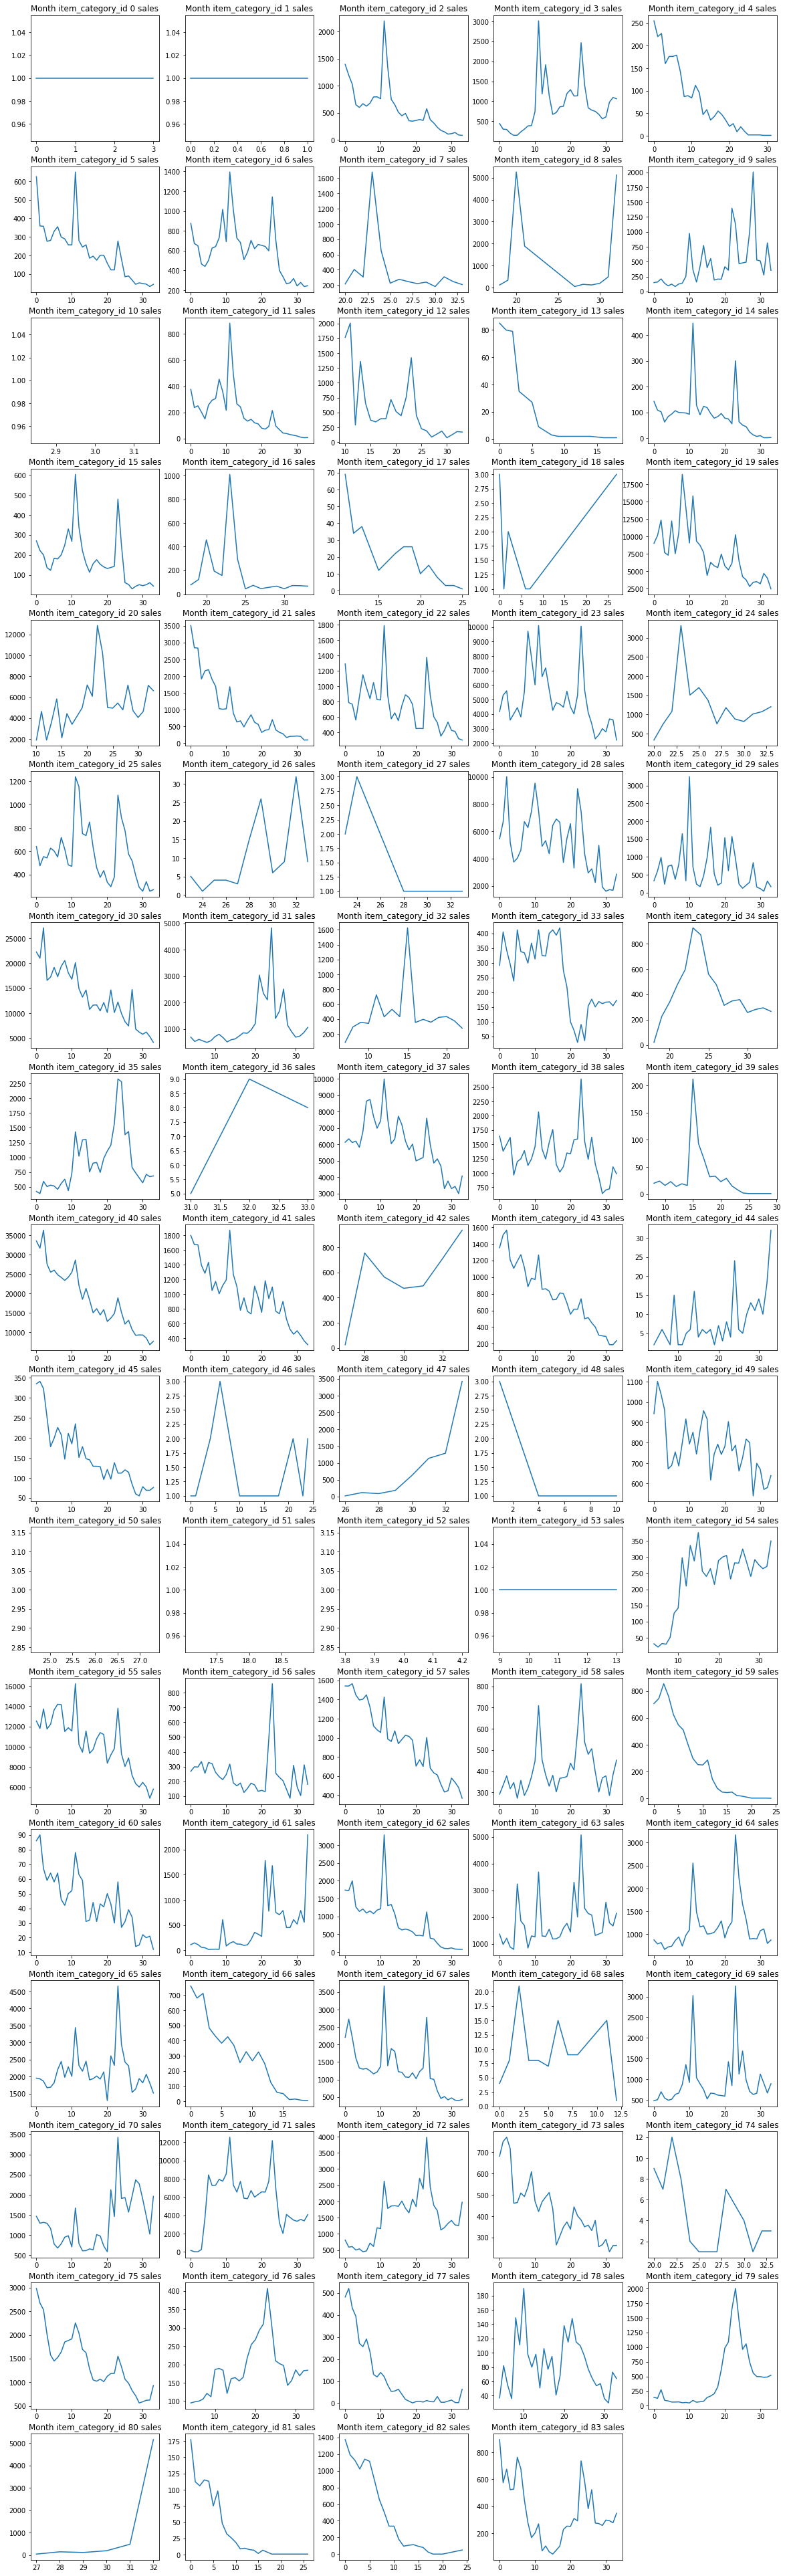

In [19]:
cat_sales = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
fc = FeatureClustering('item_category_id',cat_sales, 34)
fc.plot_graphs(cat_sales)

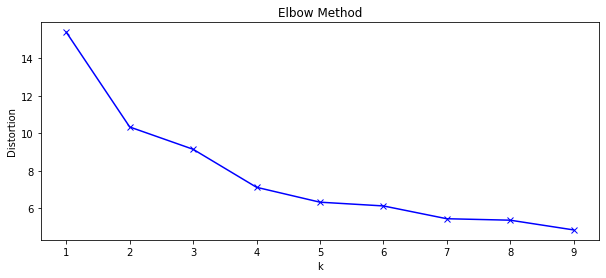

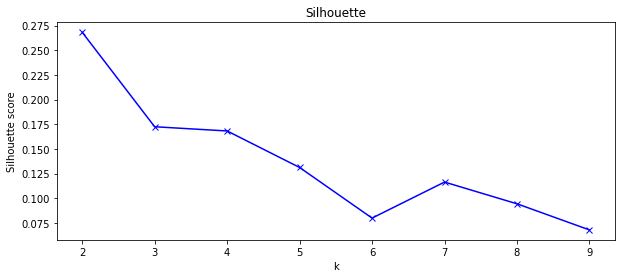

In [21]:
fc.create_data(cat_sales, StandardScaler())
fc.show_metrics()

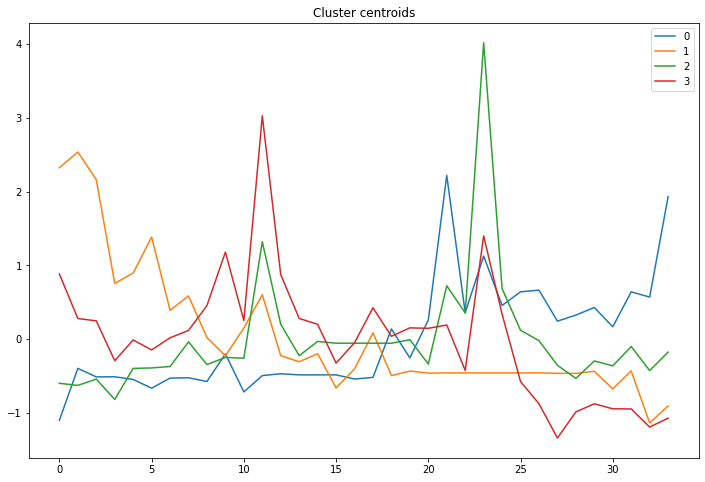

In [26]:
fc.fit_and_plot_centres(n_clusters=4)

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 84 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


                          Cluster number: 0


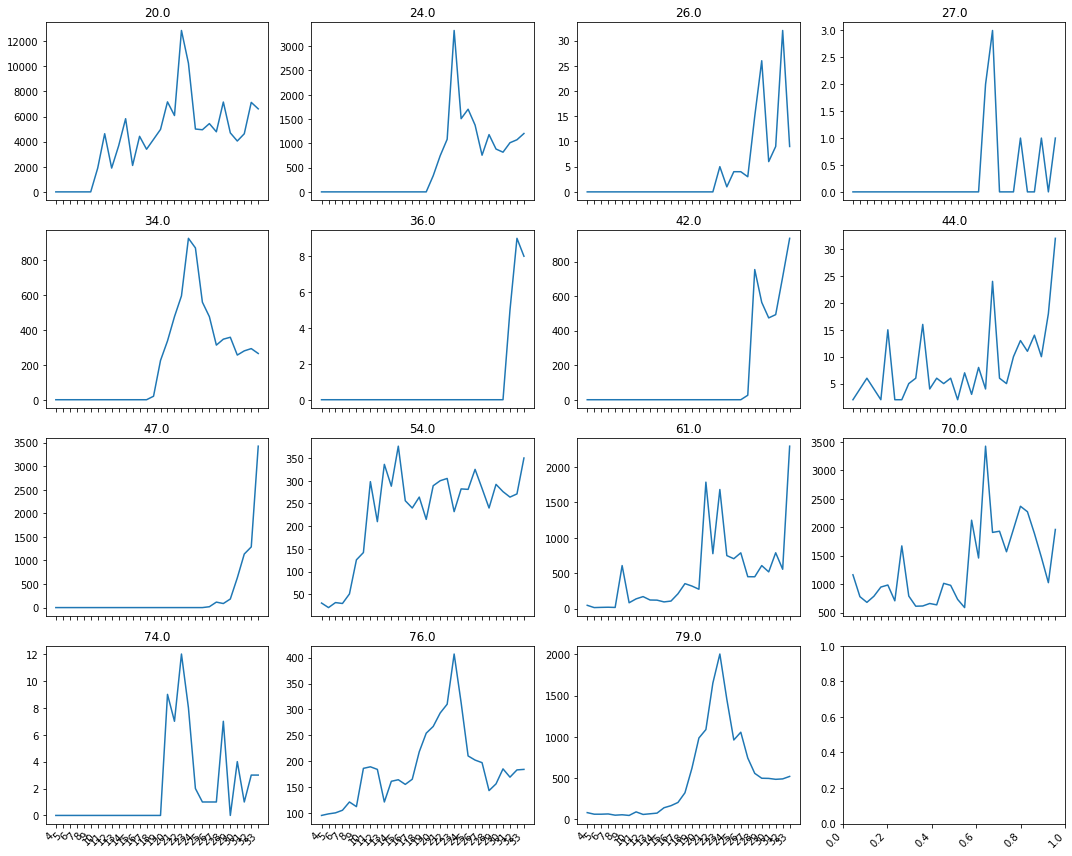

                          Cluster number: 1


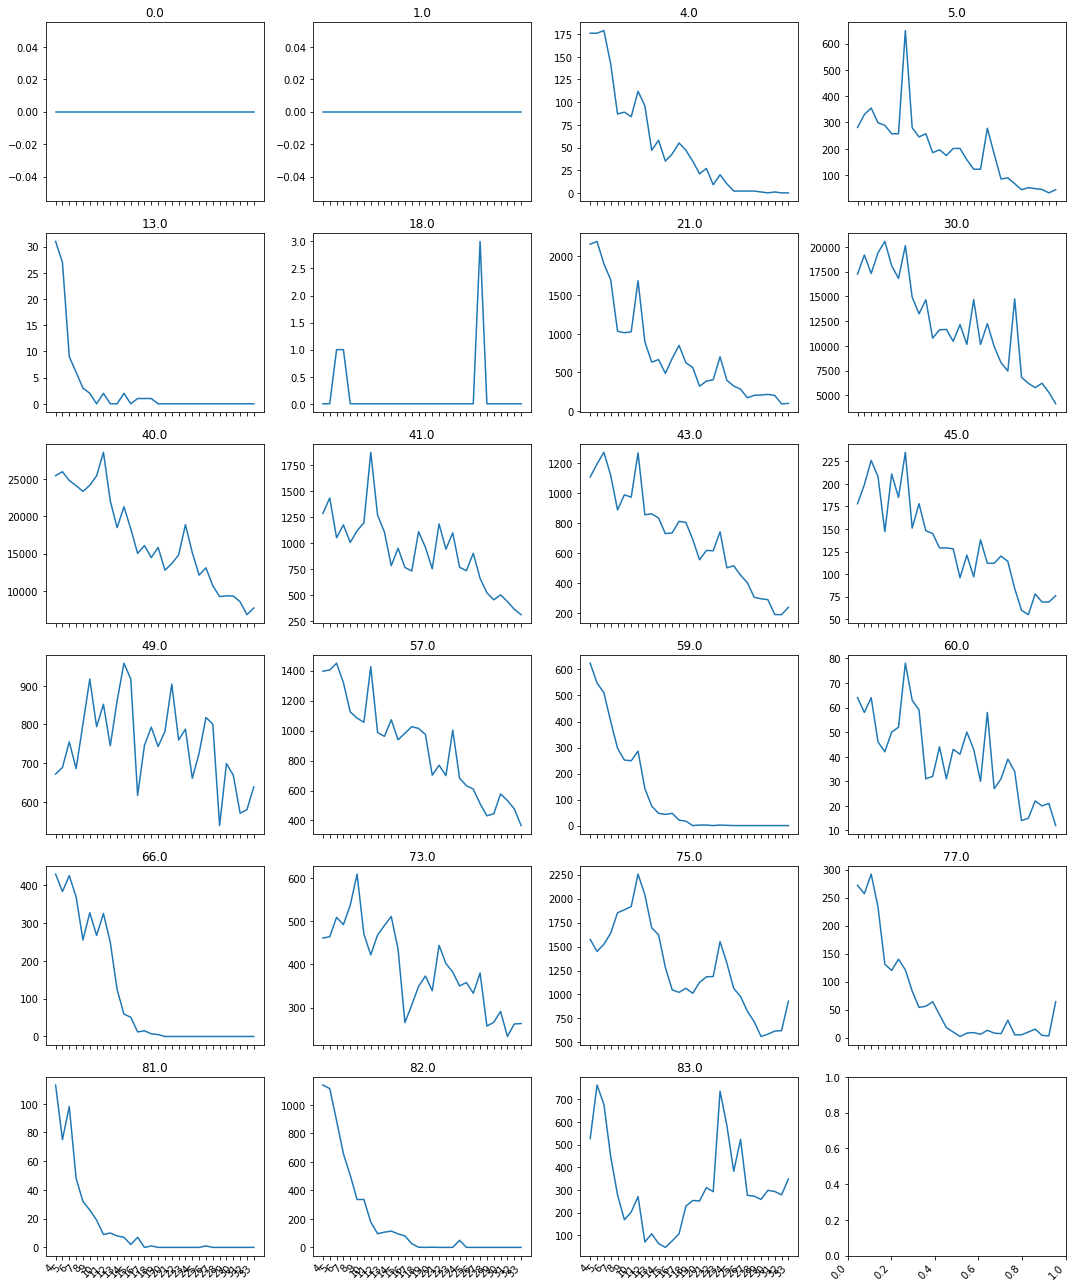

                          Cluster number: 2


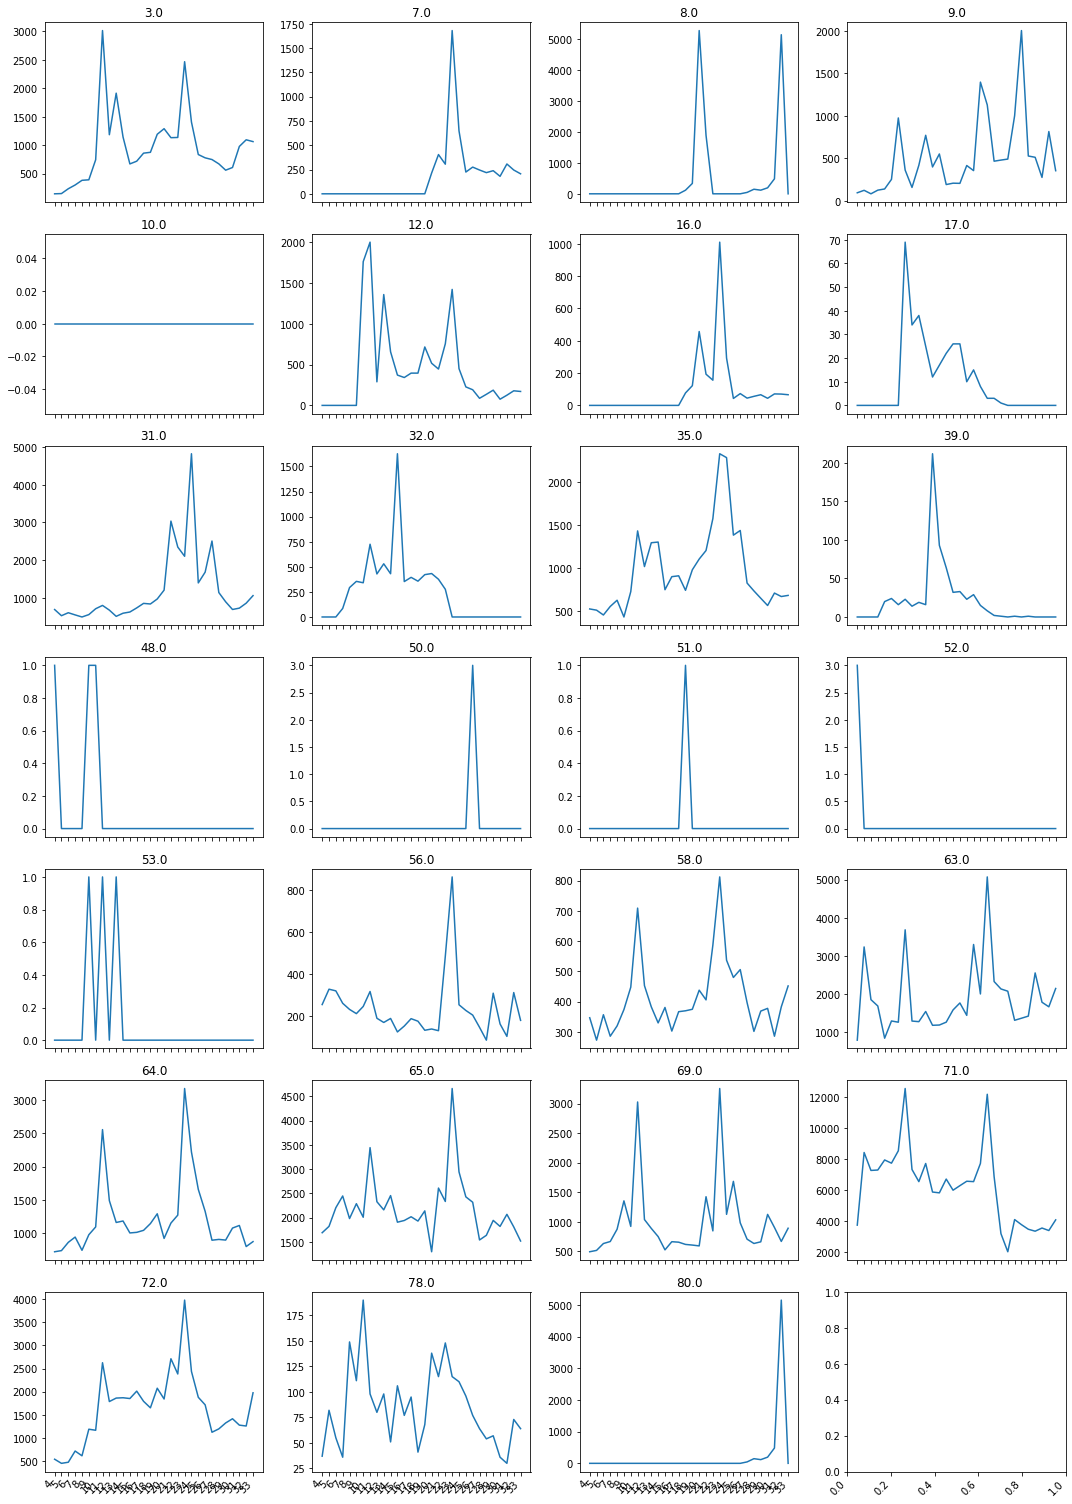

                          Cluster number: 3


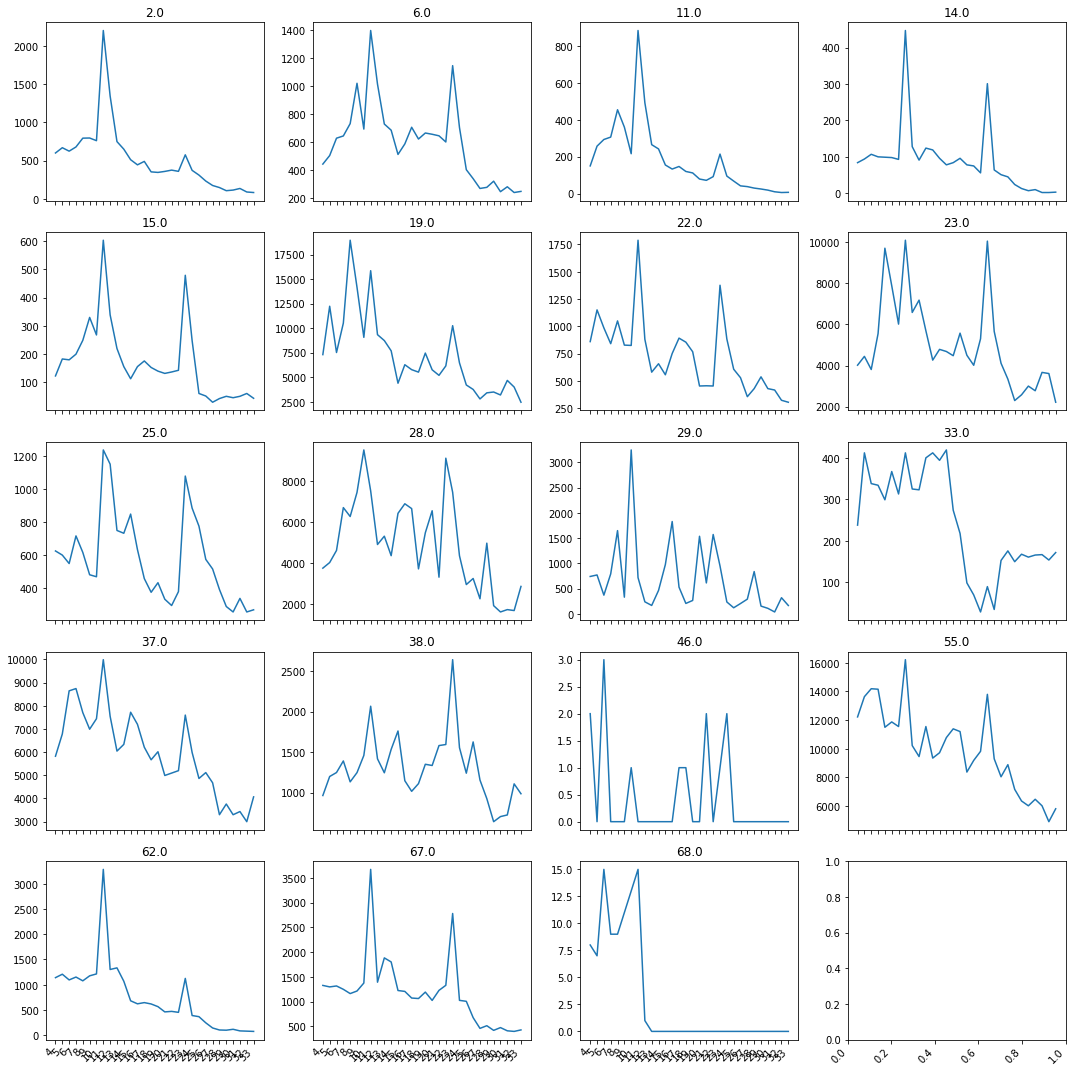

In [27]:
fc.plot_clusters()

### Shops

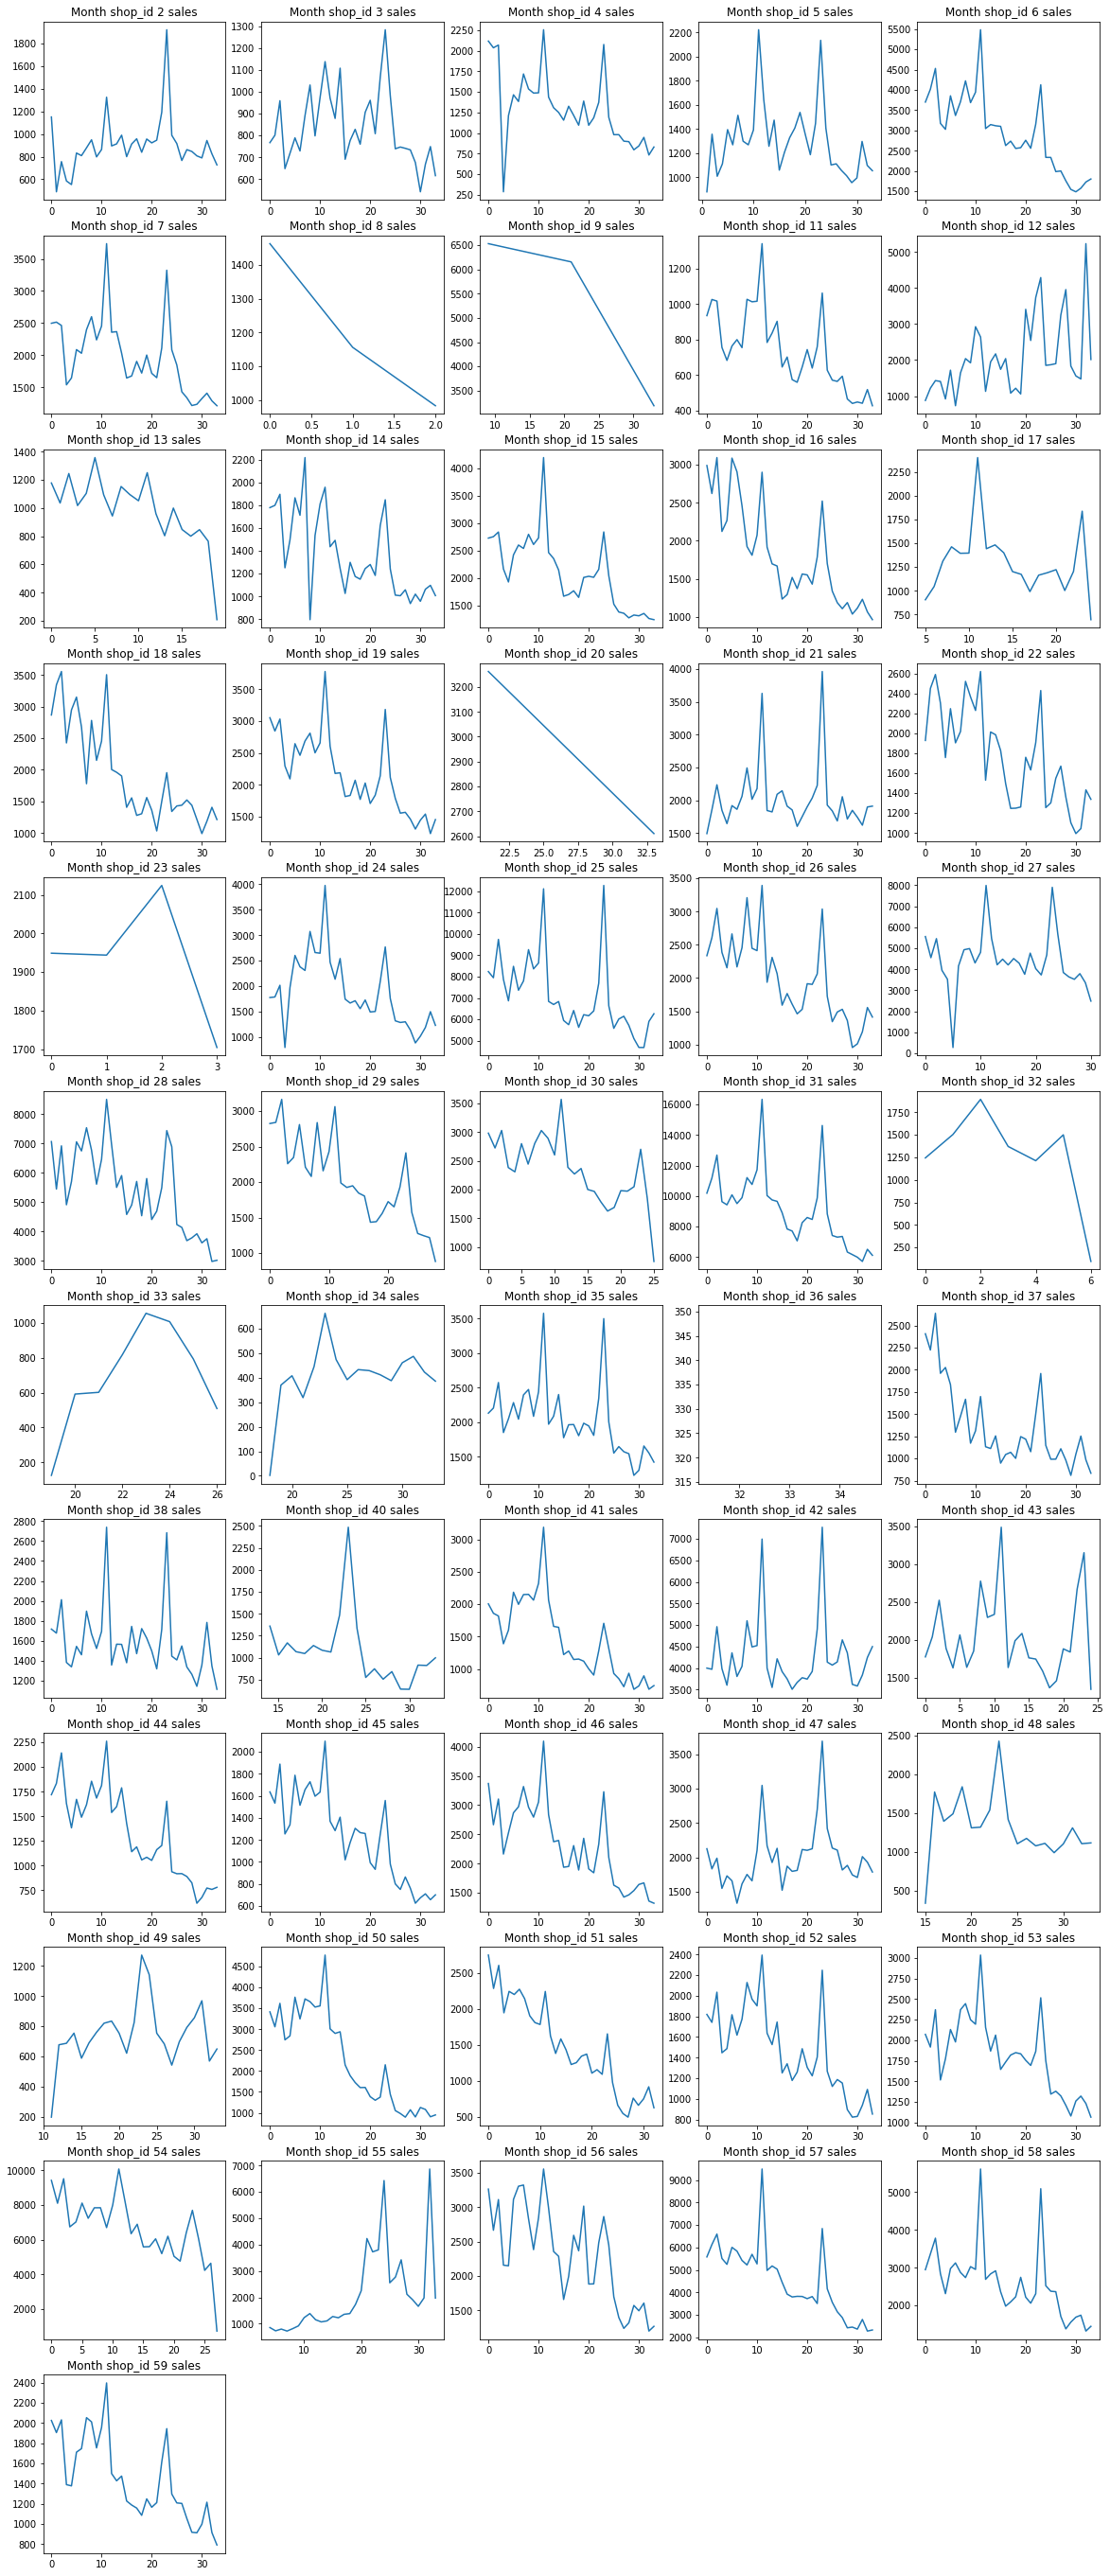

In [28]:
fc = FeatureClustering('shop_id', sales_train, 34)
fc.plot_graphs(sales_train)

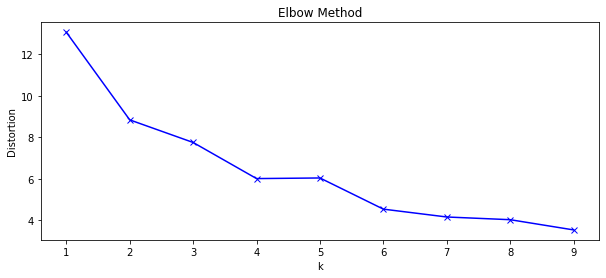

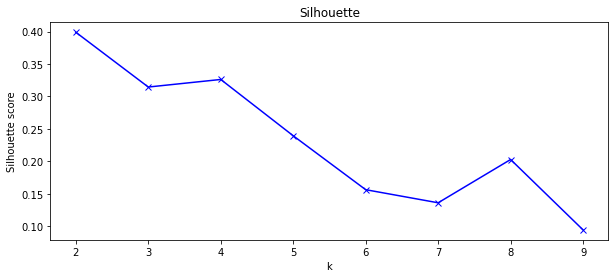

In [29]:
fc.create_data(sales_train, StandardScaler())
fc.show_metrics()

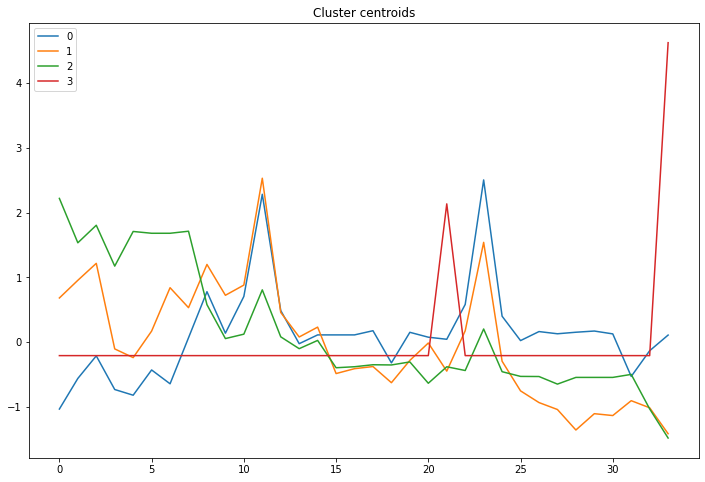

In [30]:
fc.fit_and_plot_centres(n_clusters=4)

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 56 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


                          Cluster number: 0


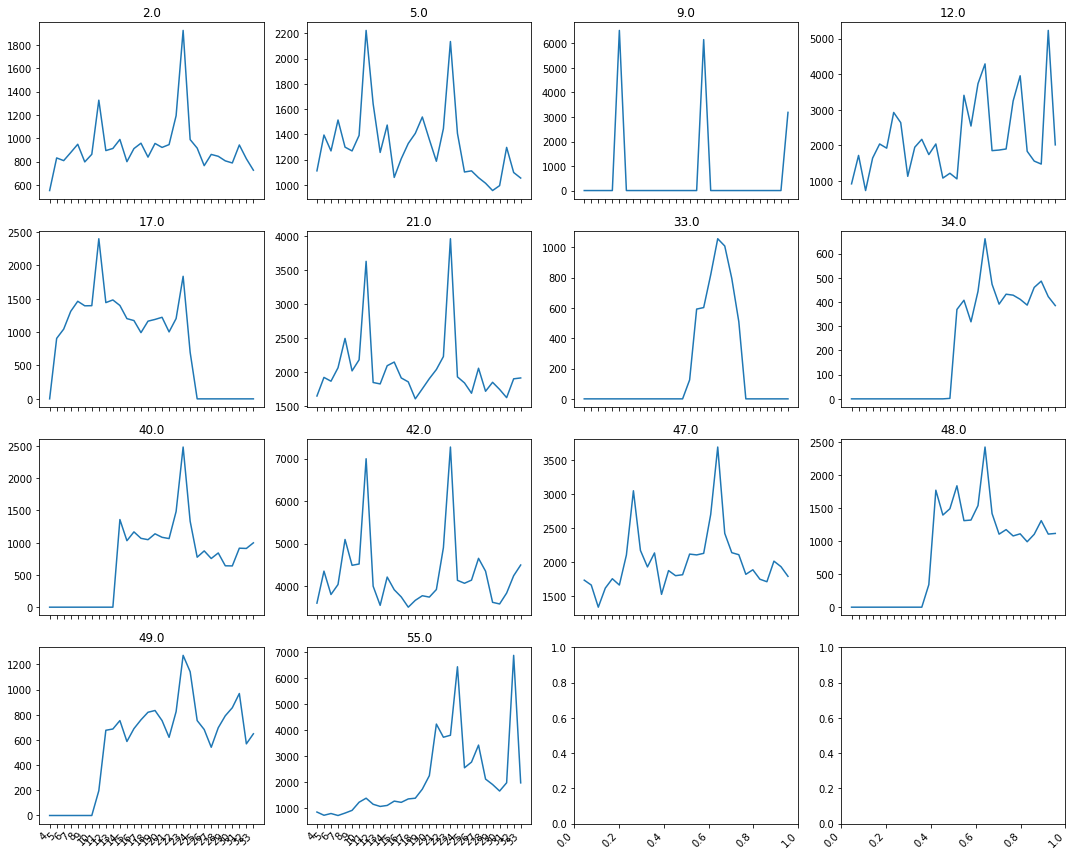

                          Cluster number: 1


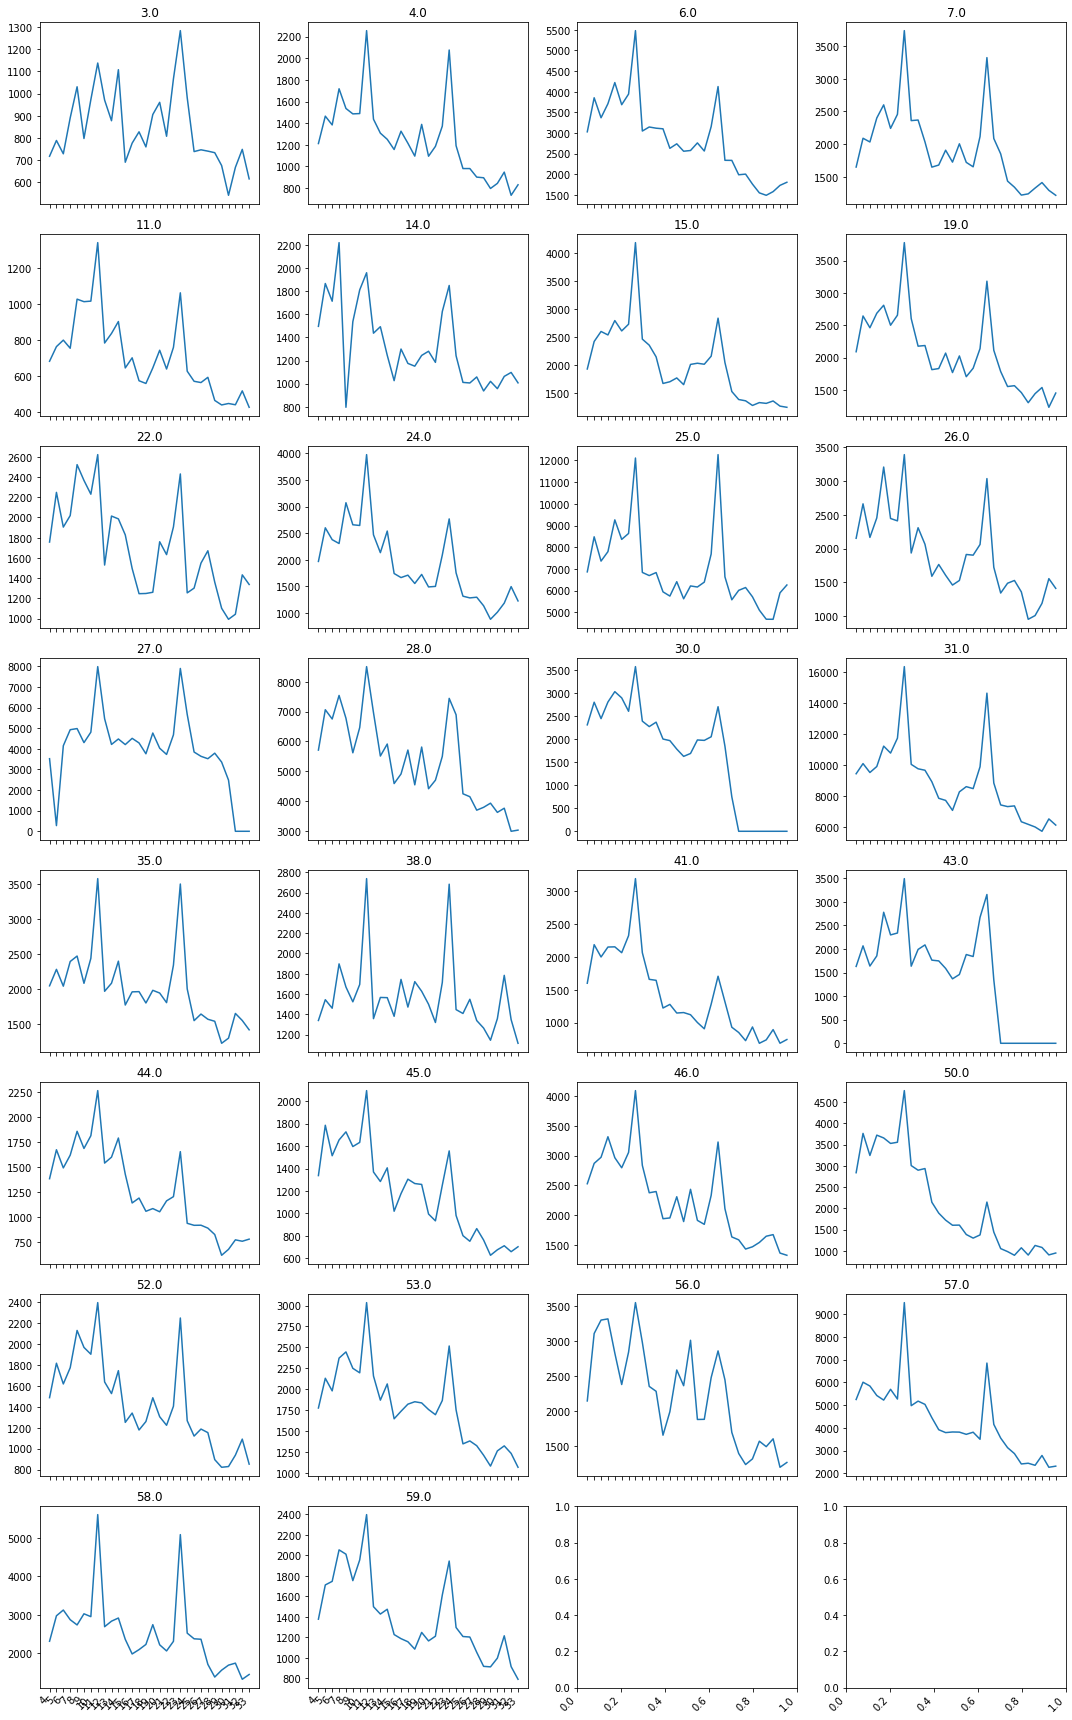

                          Cluster number: 2


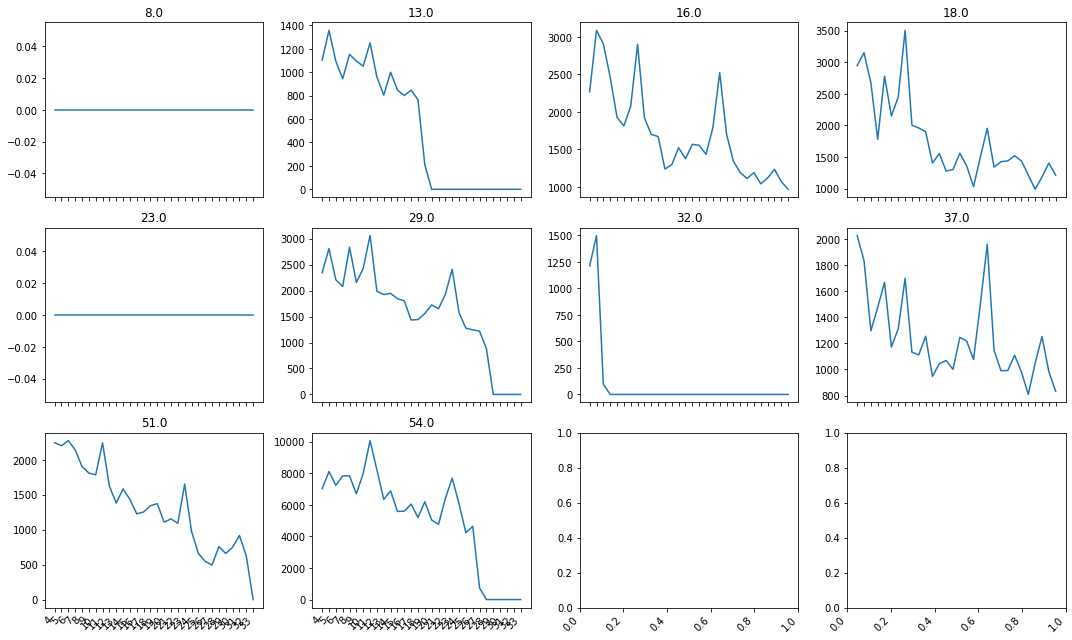

                          Cluster number: 3


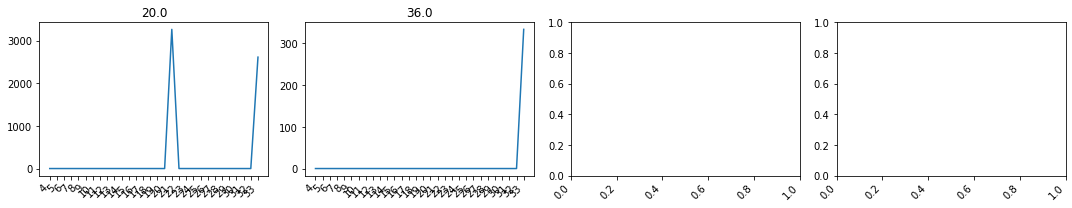

In [31]:
fc.plot_clusters()

In [ ]:
def create_city_feature(shops_df: pd.DataFrame, corrections: dict):
    shops_df['city'] = shops_df['shop_name'].str.extract(r'(\w+\.*\w*)')
    for city1, city2 in corrections.items():        
        shops_df.loc[shops_df.city == city1, 'city'] = city2
    shops_df['city'] = LabelEncoder().fit_transform(shops['city'])
    
    
corrections = {'Выездная': 'Выездная торговля', 'РостовНаДону': 'Ростов-На-Дону',
               'Сергиев': 'Сергиев Посад', 'Цифровой': 'Интернет'}
create_city_feature(shops, corrections)
shops.head()

In [ ]:
def create_train(month_range: list, all_shops: list, all_items: list):
    train = []
    for month in month_range:
        all_shops = sales_train.loc[sales_train['date_block_num'] == month, 'shop_id'].unique()
        all_items = sales_train.loc[sales_train['date_block_num'] == month, 'item_id'].unique()
        train.append(np.array(list(product([month], all_shops, all_items))))
    train = pd.DataFrame(np.vstack(train), columns=['date_block_num', 'shop_id', 'item_id'])
    return train


train = create_train(sales_train.date_block_num.unique(), sales_train.shop_id.unique(),
                     sales_train.item_id.unique())
train

In [ ]:
def aggregate_on_month_level(train_df: pd.DataFrame, sales_train_df: pd.DataFrame, test_df: pd.DataFrame): 
    group = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'}).reset_index()
    group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})
    all_data = train_df.merge(group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    
    test = test_df.merge(group[group['date_block_num'] == 33], on=['shop_id', 'item_id'], how='left')
    test = test.fillna(0)    
    test['date_block_num'] = 34

    all_data = pd.concat([all_data, test.drop(columns='ID')], ignore_index=True, keys=['date_block_num', 'shop_id', 'item_id'])
    all_data = all_data.fillna(0)
    all_data['item_cnt_month'] = all_data['item_cnt_month'].clip(0,20)
    return all_data


all_data = aggregate_on_month_level(train, sales_train, test)

In [ ]:
lags = pd.DataFrame()
for i in range(12, 35):
    temp = all_data[all_data.date_block_num == i]
    temp1 = all_data[(all_data.date_block_num == i - 1)]
    temp1 = temp1.groupby(['shop_id', 'item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp1 = temp1.rename({'item_cnt_month': 'item_cnt_last_1', 'item_price_mean': 'item_price_last_1'}, axis=1)
    
    temp1_item = all_data[(all_data.date_block_num == i - 1)]
    temp1_item = temp1_item.groupby(['item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp1_item = temp1_item.rename({'item_cnt_month': 'item_cnt_last_1_item', 'item_price_mean': 'item_price_last_1_item'}, axis=1)
    
    temp12 = all_data[(all_data.date_block_num == i - 12)]
    temp12 = temp12.groupby(['shop_id', 'item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp12 = temp12.rename({'item_cnt_month': 'item_cnt_last_12', 'item_price_mean': 'item_price_last_12'}, axis=1)
    
    temp12_item = all_data[(all_data.date_block_num == i - 12)]
    temp12_item = temp12_item.groupby(['item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp12_item = temp12_item.rename({'item_cnt_month': 'item_cnt_last_12_item', 'item_price_mean': 'item_price_last_12_item'}, axis=1)
    
    temp2 = all_data[(all_data.date_block_num == i - 2)]
    temp2 = temp2.groupby(['shop_id', 'item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp2 = temp2.rename({'item_cnt_month': 'item_cnt_last_2', 'item_price_mean': 'item_price_last_2'}, axis=1)
    
    temp2_item = all_data[(all_data.date_block_num == i - 2)]
    temp2_item = temp2_item.groupby(['item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp2_item = temp2_item.rename({'item_cnt_month': 'item_cnt_last_2_item', 'item_price_mean': 'item_price_last_2_item'}, axis=1)
    
    temp3 = all_data[(all_data.date_block_num == i - 3)]
    temp3 = temp3.groupby(['shop_id', 'item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp3 = temp3.rename({'item_cnt_month': 'item_cnt_last_3', 'item_price_mean': 'item_price_last_3'}, axis=1)
    
    temp3_item = all_data[(all_data.date_block_num == i - 3)]
    temp3_item = temp3_item.groupby(['item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
    temp3_item = temp3_item.rename({'item_cnt_month': 'item_cnt_last_3_item', 'item_price_mean': 'item_price_last_3_item'}, axis=1)
    
    temp = temp.merge(temp1, how='left', on=['shop_id', 'item_id'])
    temp = temp.merge(temp2, how='left', on=['shop_id', 'item_id'])
    temp = temp.merge(temp3, how='left', on=['shop_id', 'item_id'])
    temp = temp.merge(temp12, how='left', on=['shop_id', 'item_id'])
    temp = temp.merge(temp1_item, how='left', on=['item_id'])
    temp = temp.merge(temp2_item, how='left', on=['item_id'])
    temp = temp.merge(temp3_item, how='left', on=['item_id'])
    temp = temp.merge(temp12_item, how='left', on=['item_id'])
    
    lags = pd.concat([lags, temp], ignore_index=True)
    
lags = lags.fillna(0)
all_data = lags

In [ ]:
gc.collect()

In [ ]:
def add_lag_features(lag_months: list, month_range: range):
    lags = pd.DataFrame()
    for month in month_range:
        cur_month = all_data[all_data.date_block_num == month]
        for lag in lag_months:
            cur_lag = all_data[(all_data.date_block_num == month - lag)]
            cur_lag = cur_lag.rename({'item_cnt_month': 'item_cnt_last_{}'.format(lag),
                                      'item_price_mean': 'item_price_last_{}'.format(lag)}, axis=1)

            cur_item_lag = all_data[(all_data.date_block_num == month - lag)]
            cur_item_lag = cur_item_lag.rename({'item_cnt_month': 'item_cnt_last_{}_item'.format(lag),
                                                'item_price_mean': 'item_price_last_{}_item'.format(lag)},
                                                axis=1)

            cur_month = cur_month.merge(cur_lag.drop(columns='date_block_num'), how='left',
                                        on=['shop_id', 'item_id'])
            cur_month = cur_month.merge(cur_item_lag.drop(columns=['date_block_num', 'shop_id']),
                                        how='left', on=['item_id'])
        lags = pd.concat([lags, cur_month], ignore_index=True)
        
    lags = lags.fillna(0)
    return lags

lag_months = [1, 2, 3, 12]
month_range = range(12, all_data.date_block_num.nunique())
all_data = add_lag_features(lag_months, month_range)

In [ ]:
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_date'] = items['first_sale_date'].fillna(34)

all_data = all_data.merge(shops[['shop_id', 'city']], on='shop_id', how='left')
all_data = all_data.merge(items[['item_id', 'item_category_id', 'first_sale_date']], on='item_id', how='left')
all_data = all_data.merge(item_categories.drop('item_category_name', axis=1), on='item_category_id', how='left')
all_data.head()

In [ ]:
all_data['new_item'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data['time_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

all_data['month'] = all_data['date_block_num']%12

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_data = downcast(all_data)
del shops, items, item_categories, train, test
gc.collect()

In [ ]:
"""all_data['date_block_num'] = all_data['date_block_num'].astype("category")
all_data['shop_id'] = all_data['shop_id'].astype("category")
all_data['item_id'] = all_data['item_id'].astype("category")
all_data['city'] = all_data['city'].astype("category")
all_data['item_category_id'] = all_data['item_category_id'].astype("category")
all_data['category'] = all_data['category'].astype("category")"""

In [ ]:
"""transformer = make_column_transformer(
    (OneHotEncoder(), ['category']),
    remainder='passthrough')

transformed = transformer.fit_transform(all_data)
all_data = pd.DataFrame(transformed)
all_data = all_data.rename(columns={10: 'date_block_num', 13: 'item_cnt_month'})
all_data.head()"""

In [ ]:
X_train = all_data[all_data['date_block_num'] < 33].drop(columns=['item_cnt_month'])
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
X_valid = all_data[all_data['date_block_num'] == 33].drop(columns=['item_cnt_month'])
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']
X_test = all_data[all_data['date_block_num'] == 34].drop(columns=['item_cnt_month'])
#X_test['date_block_num'] = 22

In [ ]:
"""from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()"""

model = xgb.XGBRegressor(
    seed = 42,
    subsample = 0.9,
    n_estimators=500,
    max_depth = 10,
    learning_rate = 0.3,
    gamma = 1,
    colsample_bytree = 0.9,
    early_stopping_rounds = 50)

rmse_cross_val = []

for i in range(13, 34, 5):
    start = time.time()
    X_train = all_data[all_data['date_block_num'] < i].drop(columns=['item_cnt_month'])
    y_train = all_data[all_data['date_block_num'] < i]['item_cnt_month']
    X_valid = all_data[all_data['date_block_num'] == i].drop(columns=['item_cnt_month'])
    y_valid = all_data[all_data['date_block_num'] == i]['item_cnt_month']
    print('Fitting... {} example'.format(i))
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose = 10)
    end = time.time()
    print('Took ' + str(int(end - start)) + ' seconds to fit the model')
    rmse_cross_val.append([mean_squared_error(model.predict(X_train).clip(0, 20), y_train, squared=False), mean_squared_error(model.predict(X_valid).clip(0, 20), y_valid, squared=False)])

In [ ]:
def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='best')       
    plt.show()
    
    
months = [12, 17, 22, 27, 32]
plot_fitting_graph(months, list(map(lambda x: x[0], rmse_cross_val)), list(map(lambda x: x[1], rmse_cross_val)), xlabel='№ of months for train', ylabel='Error (RMSE)',
                   title='XGBoost CrossValidation')

In [ ]:
from sklearn.model_selection import GridSearchCV

forecaster = xgb.XGBRegressor(seed=42,
                             gamma = 1,
                             early_stopping_rounds = 50)

params = {'learning_rate': [0.05, 0.1],
              'max_depth': [7, 10],
              'min_child_weight': [4],
              'subsample': [0.9],
              'colsample_bytree': [0.9],
              'n_estimators': [250, 500]}

xgb_grid = GridSearchCV(
    estimator=forecaster,
    scoring='neg_root_mean_squared_error',
    param_grid=params,
    cv=[(slice(None), slice(None))],
    n_jobs=1)
# experiment
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose = 10)
params = xgb_grid.best_params_
score = xgb_grid.score_
print('Best params: {}'.format(params))
print('Best score: {}'.format(score))

In [ ]:
start = time.time()

model = xgb.XGBRegressor(
    seed = 42,
    subsample = 0.9,
    n_estimators=500,
    max_depth = 10,
    learning_rate = 0.3,
    gamma = 1,
    colsample_bytree = 0.9,
    early_stopping_rounds = 50)

print('Fitting...')
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose = 10)

end = time.time()
print('Took ' + str(int(end - start)) + ' seconds to fit the model')

In [ ]:
"""from boruta import BorutaPy

model = xgb.XGBRegressor(
    seed = 42,
    subsample = 0.9,
    n_estimators=500,
    max_depth = 10,
    learning_rate = 0.3,
    gamma = 1,
    colsample_bytree = 0.9)

boruta = BorutaPy(estimator = model, n_estimators = 'auto', max_iter = 100)
boruta.fit(np.array(X_train), np.array(y_train))"""

In [ ]:
"""green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', len(green_area))
print('features in the blue area:', len(X_train.columns))"""

In [ ]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
preds_train = model.predict(X_train).clip(0, 20)
print('Train set RMSE = ' + str(mean_squared_error(preds_train, y_train, squared=False)))
preds_val = model.predict(X_valid).clip(0, 20)
print('Validation set RMSE = ' + str(mean_squared_error(preds_val, y_valid, squared=False)))

In [ ]:
y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
    "ID": np.arange(y_test.shape[0]), 
    "item_cnt_month": y_test
})
submission.to_csv('s.csv', index=False)

In [ ]:
"""explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])"""